In [1]:
import time, csv
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

tf.disable_v2_behavior()

from random import shuffle

Instructions for updating:
non-resource variables are not supported in the long term


# Preprocessing data

In [2]:
train_data_path = "./dataset/timeseries/RefrigerationDevices/RefrigerationDevices_TRAIN"
test_data_path = "./dataset/timeseries/RefrigerationDevices/RefrigerationDevices_TEST"

In [3]:
train_data, train_label = [], []
with open(train_data_path) as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    train_data.append(row[1:])
    train_label.append(row[0])
      
test_data, test_label = [], []
with open(test_data_path) as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    test_data.append(row[1:])
    test_label.append(row[0])
      

In [4]:
# LENGTH = np.shape(train_data)[1]
LENGTH = 50
TRAIN_ALL_ROWS = np.shape(train_data)[0]
TRAIN_ROWS = 50
TEST_ALL_ROWS = np.shape(test_data)[0]
TEST_ROWS = 10

label_1 = 1
label_2 = 2

## train data

In [5]:
train_data = np.array(train_data, np.float32)
train_label = np.array(train_label, np.float32)
train_label = np.where(train_label == label_2, -1, 1)

index_list = [i for i in range(TRAIN_ALL_ROWS)]
shuffle(index_list)
train_data = train_data[index_list]
train_label = train_label[index_list]

train_data = train_data[:TRAIN_ROWS, :LENGTH]
train_label = train_label[:TRAIN_ROWS]
train_label = train_label.reshape(-1, 1)

## test data

In [6]:
test_data = np.array(test_data, np.float32)
test_label = np.array(test_label, np.float32)
test_label = np.where(test_label == label_2, -1, 1)

index_list = [i for i in range(TRAIN_ALL_ROWS)]
shuffle(index_list)
test_data = test_data[index_list]
test_label = test_label[index_list]

test_data = test_data[:TEST_ROWS, :LENGTH]
test_label = test_label[:TEST_ROWS]
test_label = test_label.reshape(-1, 1)

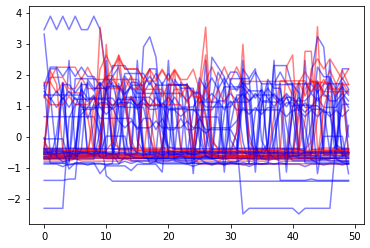

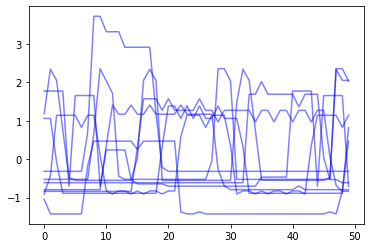

In [7]:
for i in range(TRAIN_ROWS):
  plt.plot(train_data[i].ravel(), 'b' if train_label[i] == 1 else 'r', alpha=0.5)
plt.show()

for i in range(TEST_ROWS):
  plt.plot(test_data[i].ravel(), 'b' if test_label[i] == 1 else 'r', alpha=0.5)
plt.show()

In [8]:
# batch = int(np.shape(train_x)[0] / 2)
batch = TRAIN_ROWS
iter = 5
lr = 0.01
gamma = 25.

In [9]:
X = tf.placeholder(shape=[None, None], dtype=tf.float32)
pred_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
test_X = tf.placeholder(shape=[None, None], dtype=tf.float32)

Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
test_Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)

B = tf.Variable(tf.random_uniform(shape=[1, batch]))

In [10]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [11]:
G = tf.constant(gamma)
dtw_distances = tf.py_function(func=_dtw, inp=[X, X], Tout=[tf.float32 for i in range(batch)])

#kernel = tf.exp(-tf.multiply(G, dtw_distances))
kernel = tf.exp(tf.divide(-tf.square(dtw_distances), tf.square(G)))

In [12]:
first_term = tf.reduce_sum(B)

second_term = tf.reduce_sum(
  tf.multiply(
    kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [13]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[X, pred_X], Tout=[tf.float32 for i in range(batch)])
#pred_kernel = tf.exp(-tf.multiply(G, pred_dtw_distances))
pred_kernel = tf.exp(tf.divide(-tf.square(pred_dtw_distances), tf.square(G)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(Y)), tf.float32))

In [14]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[X, test_X], Tout=[tf.float32 for i in range(batch)])
# test_kernel = tf.exp(-tf.multiply(G, test_dtw_distances))
test_kernel = tf.exp(tf.divide(-tf.square(test_dtw_distances), tf.square(G)))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_Y)), tf.float32))

In [15]:
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [16]:
start = time.time()

loss_vec = []
batch_accuracy = []

rand_index = []
for i in range(iter):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(TRAIN_ROWS, size=batch, replace=False)
  rand_x = train_data[rand_index]
  rand_y = train_label[rand_index]

  sess.run(train, feed_dict={X: rand_x, Y: rand_y})
  temp_loss = sess.run(loss, feed_dict={X: rand_x, Y: rand_y})
  loss_vec.append(temp_loss)
  acc_temp = sess.run(accuracy, feed_dict={X: rand_x, Y: rand_y, pred_X: rand_x})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
accuracy : 0.68
loss: 1.5434265
time : 83.16751098632812
Step #2
accuracy : 0.74
loss: -2.4750938
time : 82.82983708381653
Step #3
accuracy : 0.68
loss: -2.7513561
time : 82.51889705657959
Step #4
accuracy : 0.66
loss: -2.0535583
time : 82.91943597793579
Step #5
accuracy : 0.68
loss: 7.360672
time : 82.82191514968872
Total time : 414.2582440376282


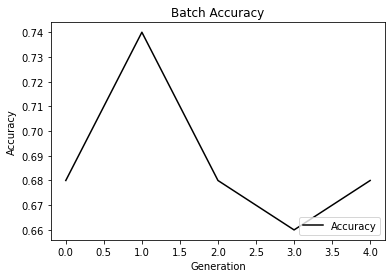

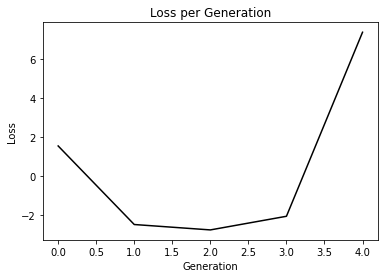

In [17]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [18]:
test_preds = sess.run(test_prediction,
                      feed_dict={
                          X: train_data[rand_index],
                          Y: train_label[rand_index],
                          test_X: test_data
                      })

print(test_preds)
print(test_label)

[[ 1. -1.  1. -1. -1.  1. -1.  1. -1.  1.]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [19]:
test_acc = sess.run(test_accuracy,
                      feed_dict={
                          X: train_data[rand_index],
                          Y: train_label[rand_index],
                          test_X: test_data,
                          test_Y: test_label
                      })
print(test_acc)


0.5


## Influence function

### Gradient for target data

In [20]:
inf_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
inf_dtw_distances = tf.py_function(func=_dtw, inp=[X, inf_X], Tout=[tf.float32 for i in range(batch)])
# inf_kernel = tf.exp(-tf.multiply(G, inf_dtw_distances))
inf_kernel = tf.exp(tf.divide(-tf.square(inf_dtw_distances), tf.square(G)))


In [21]:
inf_first_term = tf.reduce_sum(B)
inf_second_term = tf.reduce_sum(
  tf.multiply(
    inf_kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

inf_loss = tf.negative(tf.subtract(inf_first_term, inf_second_term))

grad_op = tf.gradients(inf_loss, [B])
hess_op = tf.hessians(inf_loss, [B])

In [22]:
def get_inf(test_index):
  print('test index is ', test_index, 'test_label is ', test_label[test_index])
  print(rand_index)

  z_test_grad = sess.run(grad_op, feed_dict={
    X: train_data[rand_index],
    Y: train_label[rand_index],
    inf_X: [test_data[test_index]]
  })
  z_test_grad = np.squeeze(z_test_grad)
  hess = sess.run(hess_op, feed_dict={
    X: train_data[rand_index],
    Y: train_label[rand_index],
    inf_X: train_data
  })

  hess = np.squeeze(hess)
  inv_hess = np.linalg.inv(hess)

  infs = []

  for i in range(len(rand_index)):
    train_index = rand_index[i]
    train_grad = sess.run(grad_op,
                          feed_dict={
                            X: train_data[rand_index],
                            Y: train_label[rand_index],
                            inf_X: [train_data[train_index]]
                          })

    train_grad = np.squeeze(train_grad)
    z_hess_grad = np.matmul(inv_hess, train_grad)
    inf_val = -(np.matmul(z_test_grad, z_hess_grad) / TRAIN_ROWS)

    # infs.append((train_index, test_index, inf_val))
    dist = fastdtw(train_data[train_index], test_data[test_index], dist=euclidean)[0]
    infs.append((train_index, test_index, inf_val, dist))

  infs = sorted(infs, key=lambda x: x[2])
  return infs

In [23]:
infs = []
for i in range(TEST_ROWS):
  infs.append(get_inf(i))

test index is  0 test_label is  [1]
[29 13  4 33 17 12 11 18  5 21 26 16 23  7 14 34 38 22 27 25 24  2 32 30
 28 19 42 43 15 46 41 40 47 39 45  9  0 10  3 20 36 48  1 31 49 37  8 35
 44  6]
test index is  1 test_label is  [1]
[29 13  4 33 17 12 11 18  5 21 26 16 23  7 14 34 38 22 27 25 24  2 32 30
 28 19 42 43 15 46 41 40 47 39 45  9  0 10  3 20 36 48  1 31 49 37  8 35
 44  6]
test index is  2 test_label is  [1]
[29 13  4 33 17 12 11 18  5 21 26 16 23  7 14 34 38 22 27 25 24  2 32 30
 28 19 42 43 15 46 41 40 47 39 45  9  0 10  3 20 36 48  1 31 49 37  8 35
 44  6]
test index is  3 test_label is  [1]
[29 13  4 33 17 12 11 18  5 21 26 16 23  7 14 34 38 22 27 25 24  2 32 30
 28 19 42 43 15 46 41 40 47 39 45  9  0 10  3 20 36 48  1 31 49 37  8 35
 44  6]
test index is  4 test_label is  [1]
[29 13  4 33 17 12 11 18  5 21 26 16 23  7 14 34 38 22 27 25 24  2 32 30
 28 19 42 43 15 46 41 40 47 39 45  9  0 10  3 20 36 48  1 31 49 37  8 35
 44  6]
test index is  5 test_label is  [1]
[29 13  4 33 1

test index is  0
test index is  1
test index is  2
test index is  3
test index is  4
test index is  5
test index is  6
test index is  7
test index is  8
test index is  9


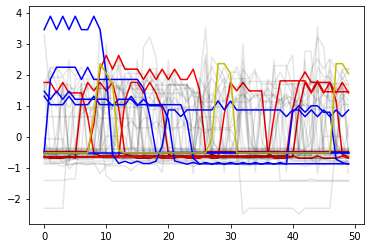

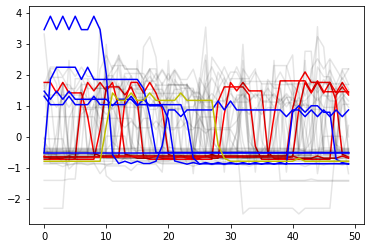

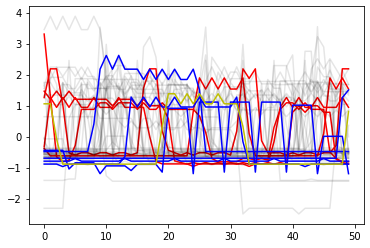

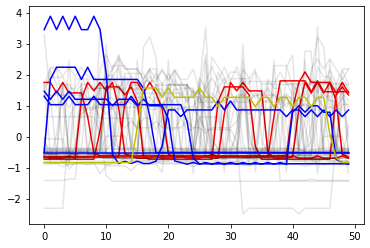

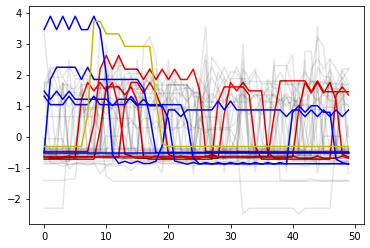

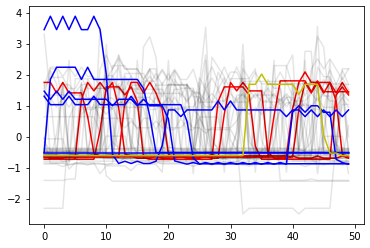

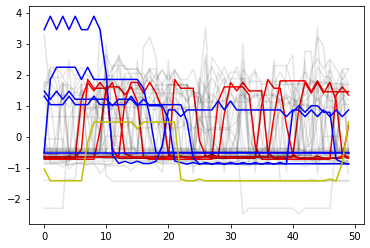

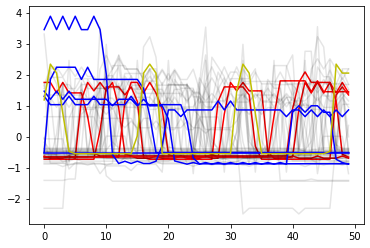

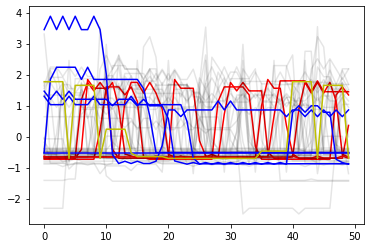

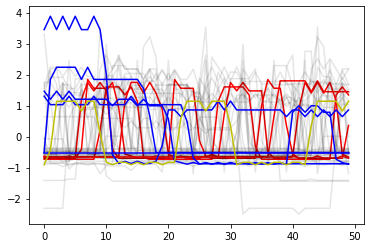

In [24]:
inf_cnt = 5
for i in range(len(infs)):
  inf = infs[i]
  test_index = inf[0][1]
  for j in range(len(inf)):
    train_index = inf[j][0]

    alpha = 0.1
    color = 'k'
    if j < inf_cnt:
      color = 'r'
      alpha = 1.
    elif j > TRAIN_ROWS - inf_cnt - 1:
      color = 'b'
      alpha = 1.

    plt.plot(train_data[train_index], color, alpha=alpha)

  plt.plot(test_data[test_index], 'y', alpha=1.)
  print('test index is ', inf[0][1])
  plt.show()

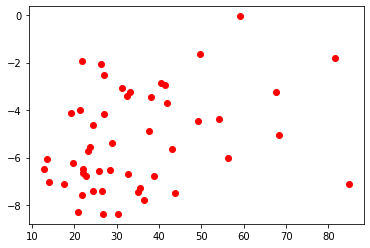

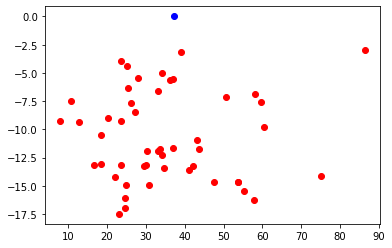

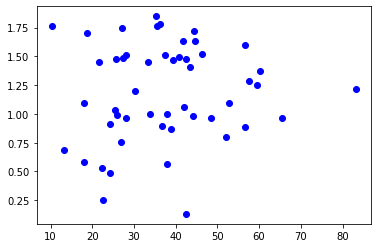

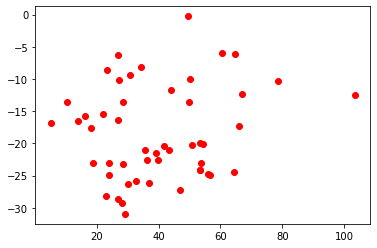

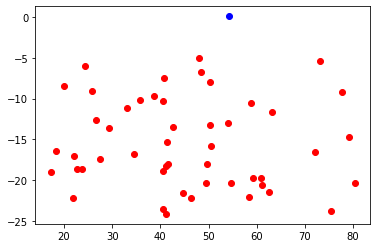

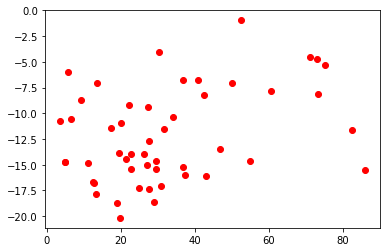

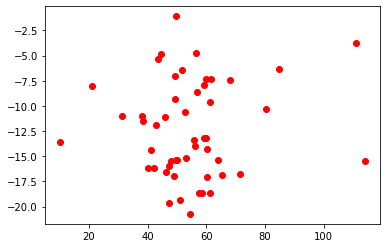

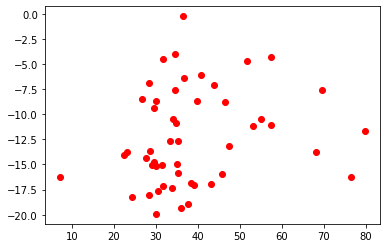

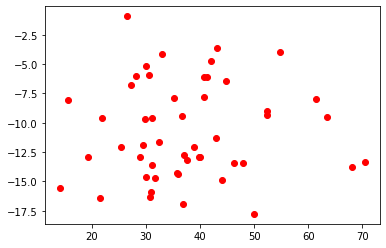

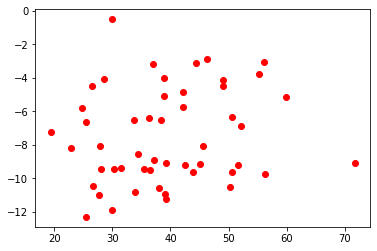

In [27]:
for i in range(len(infs)):
  inf = infs[i]
  positive, negative = [], []
  for v in inf:
    if v[2] > 0:
      positive.append((v[2], v[3]))
    else:
      negative.append((v[2], v[3]))

  plt.plot([a[1] for a in positive], [b[0] for b in positive], 'bo')
  plt.plot([a[1] for a in negative], [b[0] for b in negative], 'ro')
  plt.show()